# Extract clusters from latent space

- Load encoded data
- Load labels if they are not part of encoded data
- Plot lspace clustering for insight
- Try to extract groups of clusters
- Plot classified groups


In [1]:
import os
workdir = '/gpfs/home3/mizeboud/'
os.chdir(os.path.join(workdir,'preprocessing/scripts/train-vae/'))
import numpy as np
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt

# own modules
import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import rioxarray as rioxr


print('---- modules imported')
os.chdir(workdir)


2023-01-19 13:31:59.034178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---- modules imported


### Define model

In [2]:

# path_to_traindir = os.path.join(workdir,'train','2022-11','2022-11-17')
# # model_dir = 'model_1667487343' # 3 nov
# # model_dir = 'model_1668077484' # 10 nov
# model_dir = 'model_1668760449'


path_to_traindir = os.path.join(workdir,'train','2022-12','2022-12-01')
model_dir = 'model_1670420388_WLKF_100_2_3_16_alpha-200'
cutout_size = 100

# path_to_model = glob.glob(os.path.join(path_to_traindir , model_dir))
path_to_model = os.path.join(os.path.expanduser('~'), path_to_traindir , model_dir)
path_to_model

'/gpfs/home3/mizeboud/train/2022-12/2022-12-01/model_1670420388_WLKF_100_2_3_16_alpha-200'

### Define data tile

In [6]:


# Training tile
tileNum = 'tile_140'
tile_file = '/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_140.tif'
dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_140_300m_damageContin.tif'

# Validation tile:
# tileNum = 'tile_50'
# tile_file = "/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_50.tif"
# dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_50_300m_damageContin.tif'


tileName = tile_file.split("/")[-1][:-4] 
tileName
    

'S2_composite_2019-11-1_2020-3-1_tile_140'

### Functions

In [7]:
def create_cutouts2(da,cutout_size, normThreshold=None, equalise=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    tile_cutouts_da = da.transpose('sample','x_win','y_win','band')

    return tile_cutouts, tile_cutouts_da

def plot_lspace_4d(tile_cutouts_da, encoded_data,figsize=(12,10) ):
    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]
    z2 = encoded_data[:,2]
    z3 = encoded_data[:,3]

    # add z0 only to (sample,x,y. )
    L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
    L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()
    L_space_xy_z2 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z2,axis=1) ) #.unstack()
    L_space_xy_z3 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z3,axis=1) ) #.unstack()

    fig,axes = plt.subplots(2,2,figsize=figsize) # (20,10)

    L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[0,0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) #,vmin=-0.1,vmax=0.1, # vmin=-2 vmax=2
    axes[0,0].set_title('z0')
    axes[0,0].set_aspect('equal')

    L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[0,1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-0.1,vmax=0.1,
    axes[0,1].set_title('z1')
    axes[0,1].set_aspect('equal')

    L_space_xy_z2.unstack().isel(band=0).plot.imshow(ax=axes[1,0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-2 vmax=2
    axes[1,0].set_title('z2')
    axes[1,0].set_aspect('equal')

    L_space_xy_z3.unstack().isel(band=0).plot.imshow(ax=axes[1,1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-2 vmax=2
    axes[1,1].set_title('z3')
    axes[1,1].set_aspect('equal')

    # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_spatial_lspace'))
    # fig.savefig(os.path.join(path_to_model, tileNum + '_spatial_lspace' + '_epoch'+str(epoch_num) ))
    
    
def plot_lspace_2d(tile_cutouts_da, encoded_data ,figsize=(12,10)):
    
    z0 = encoded_data[:,0]
    z1 = encoded_data[:,1]

    # add z0 only to (sample,x,y. )
    L_space_xy_z0 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z0,axis=1) ) #.unstack()
    L_space_xy_z1 =  tile_cutouts_da.isel(band=[0],x_win=0,y_win=0).copy(deep=True, data=np.expand_dims(z1,axis=1) ) #.unstack()

    fig,axes = plt.subplots(1,2,figsize=figsize) # (20,10)

    L_space_xy_z0.unstack().isel(band=0).plot.imshow(ax=axes[0],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) #,vmin=-0.1,vmax=0.1, # vmin=-2 vmax=2
    axes[0].set_title('z0')
    axes[0].set_aspect('equal')

    L_space_xy_z1.unstack().isel(band=0).plot.imshow(ax=axes[1],x='x',cmap='RdBu',cbar_kwargs={'fraction':0.04}) # vmin=-0.1,vmax=0.1,
    axes[1].set_title('z1')
    axes[1].set_aspect('equal')

    # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_spatial_lspace'))
    # fig.savefig(os.path.join(path_to_model, tileNum + '_spatial_lspace' + '_epoch'+str(epoch_num) ))


def plot_latentspace_clusters( embedded_data,labels, clabel='label' ,figsize=(8,8)):    
    marksize = 2
    if len(labels.shape)>1:
        labels = np.squeeze(labels)
    
    # sort data with label value so that labelled pixes will be on top
    embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    labels = np.sort(labels,axis=0)
    
    # split data in points with (no) label value
    z0 = embedded_data[:, 0]
    z1 = embedded_data[:, 1]
    
    
    fig, ax1 = plt.subplots(1, figsize=figsize )
    s1 = ax1.scatter(z0, z1, c=labels, s=marksize, cmap='cividis_r') # also add size for scatter point
    # s0 = ax1.scatter(z0_label0, z1_label0, color='red', s=marksize, ) # also add size for scatter point
    # s1 = ax1.scatter(z0_label1, z1_label1, c=labels[labels>0], s=marksize, cmap='cividis_r') # also add size for scatter point
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]");
    fig.colorbar(s1,ax=ax1,label=clabel); 
    return fig, ax1


def load_nerd_dmg_tile_labels(dmg_file,tile_da, cutout_size):
    ''' ----------
    Load Labels: processed dmg
    ------------'''
    
    tile_dmg = rioxr.open_rasterio(dmg_file).astype("float32")

    # interpolate dmg to same resolution as tile (to link as labels)
    tile_dmg_int = tile_dmg.isel(band=0).interp_like(tile_da.isel(band=0))
    tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim
            
    label_cutouts, label_cutouts_da = create_cutouts2(tile_dmg_int, cutout_size)  
    labels_ldim = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)  
    labels_ldim_da = label_cutouts_da.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)      
    return labels_ldim, labels_ldim_da


def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray
    
    return da

    

### Load encoded data; plot lspace

----
 loaded encoder encoder_epoch_6
---- loaded encoded data epoch 6; size: (15625, 2)


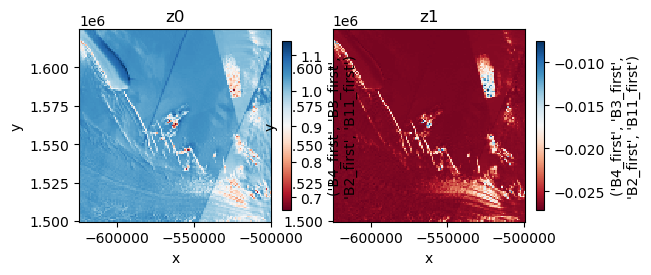

In [8]:

''' ----------
Load model/encoder
------------'''

# -- load encoder
encoder_dirs = glob.glob(path_to_model+'/encoder*')
encoder_dirs.sort()

# -- (A) select the last encoder

# path_to_encoder_epoch = encoder_dirs[-1]

# -- (B) do all epochs
for path_to_encoder_epoch in [encoder_dirs[6]]:

    epoch_num = path_to_encoder_epoch.split('_')[-1]
    encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work
    # Get latent_dim (of sampling layer)
    latent_dim = encoder.layers[-1].output_shape[-1] 

    # print('----\n loaded model {} and encoder {}'.format(os.path.split(path_to_model_epoch)[-1] ,os.path.split(path_to_encoder_epoch)[-1] ) )
    print('----\n loaded encoder {}'.format(os.path.split(path_to_encoder_epoch)[-1] ) )

    ''' ----------
    Read tile and dmg-labels; make cutouts
    ------------'''

    # read tile - floats are required to mask with NaN's
    tile_da = rioxr.open_rasterio(tile_file).astype("float32")
    
    _, tile_cutouts_da = create_cutouts2(tile_da,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 1)
    
    labels, labels_ldim_da = load_nerd_dmg_tile_labels(dmg_file, tile_da, cutout_size=cutout_size)

    ''' ----------
    Encode input / load encoded input
    ------------'''
    tileName 
    encoded_data_file = os.path.join(path_to_model, tileName + "_encoded" + '_epoch'+str(epoch_num) +".npy")

    if os.path.exists(encoded_data_file):
        # read file
        encoded_data = np.load(encoded_data_file)
        print('---- loaded encoded data epoch {}; size: {}'.format(epoch_num, encoded_data.shape))

    
    ''' ----------
    Plot latent space spatially 
    ------------'''

    if latent_dim == 4:
        plot_lspace_4d(tile_cutouts_da, encoded_data )
    if latent_dim == 2:
        plot_lspace_2d(tile_cutouts_da, encoded_data,figsize=(6,5 ))
    
    

In [9]:
# normalise tile
tile_da = normalise_and_equalise(tile_da,normThreshold=15000,equalise=False)



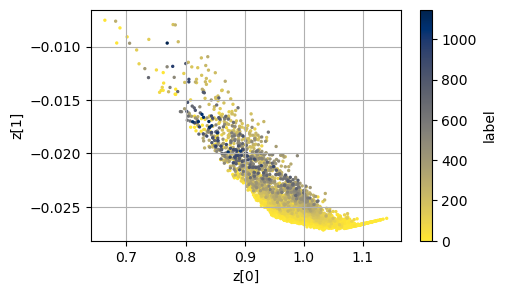

In [10]:
fig,ax = plot_latentspace_clusters(encoded_data,labels,figsize=(5,3))
ax.grid('on')

## Dev: extract clusters - most simple approach: trhreshold values
* Z1 condition: z1 > -0.025
* Z2 condition: z2 < 1.01

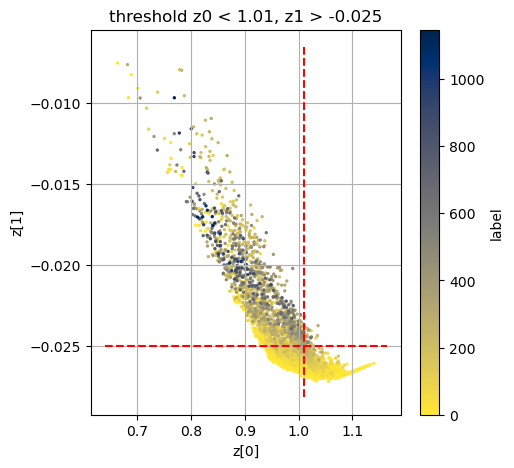

In [11]:
z1_gt = -0.025;
z0_lt = 1.01;

fig,ax = plot_latentspace_clusters(encoded_data,labels,figsize=(5,5))
ax.grid('on')
ylim=ax.get_ylim(); xlim=ax.get_xlim();
ylim
ax.plot([z0_lt, z0_lt], ylim, 'r--')
ax.plot(xlim,[z1_gt, z1_gt],'r--')
ax.set_title('threshold z0 < {}, z1 > {}'.format(z0_lt,z1_gt));

# fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_clusterSelection.png'))


In [12]:
labels.shape

(15625, 1)

In [13]:
encoded_data  # nd.array (Nsamples,2)      
labels.shape # no.darray (Nsamples,1)   
tile_cutouts_da.shape # (Nsamples,xwin, ywin, bands)      
tile_cutouts_da # xarray

z0 = encoded_data[:,0]
z1 = encoded_data[:,1]

idx_z0 = encoded_data[:,0] < z0_lt
idx_z1 = encoded_data[:,1] > z1_gt
idx_cluster = np.expand_dims(np.vstack([idx_z0,idx_z1]).all(axis=0).astype(int),axis=1) # idx where both conditions are true -- boolean converted to 0-1
idx_cluster.shape # (Nsamples,1)

# idx_cluster # .sum()

(15625, 1)

In [14]:
np.equal(idx_cluster,labels).all()
print(idx_cluster.sum(), (labels>0).sum())


1582 3564


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


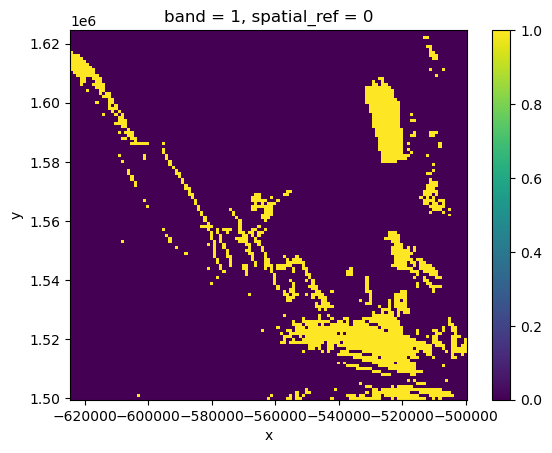

In [15]:
# Make a spatial single-band img from d-detect; then overlap later with tile_da
idx_cluster
labels_ldim_da # (Nsamples, 1)

idx_cluster_da = labels_ldim_da.copy(deep=True, data=idx_cluster) # (Nsamples,1)
cluster_da = idx_cluster_da.unstack().transpose('band','y','x') # (band, x, y)
labels_da = labels_ldim_da.unstack().transpose('band','y','x')

cluster_da.isel(band=0).plot.imshow()

In [16]:
# da # band y x = 3,y,x
# img # band y x = 1, y, x
# img_to_match_to
# img.transpose('band','y','x')

In [17]:
# ## EXAMPLE 
# import rasterio as rio

# 
# img_to_match_to = da[dict(band=slice(0,1))] # da.isel(band=0)
# img = cluster_da.transpose('band','y','x')

# # -- match grid (extent, resolution and projection)
# img_repr_match = img.rio.reproject_match(img_to_match_to,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308

# # advised to update coords
# img_repr_match = img_repr_match.assign_coords({
#     "x": img_to_match_to.x,
#     "y": img_to_match_to.y,
# })
# da_conc = xr.concat([img_to_match_to, img_repr_match],dim='band',join='outer',coords='all',combine_attrs='drop_conflicts')#,fill_value=1)
# da_conc

In [18]:
# cluster_da # .shape

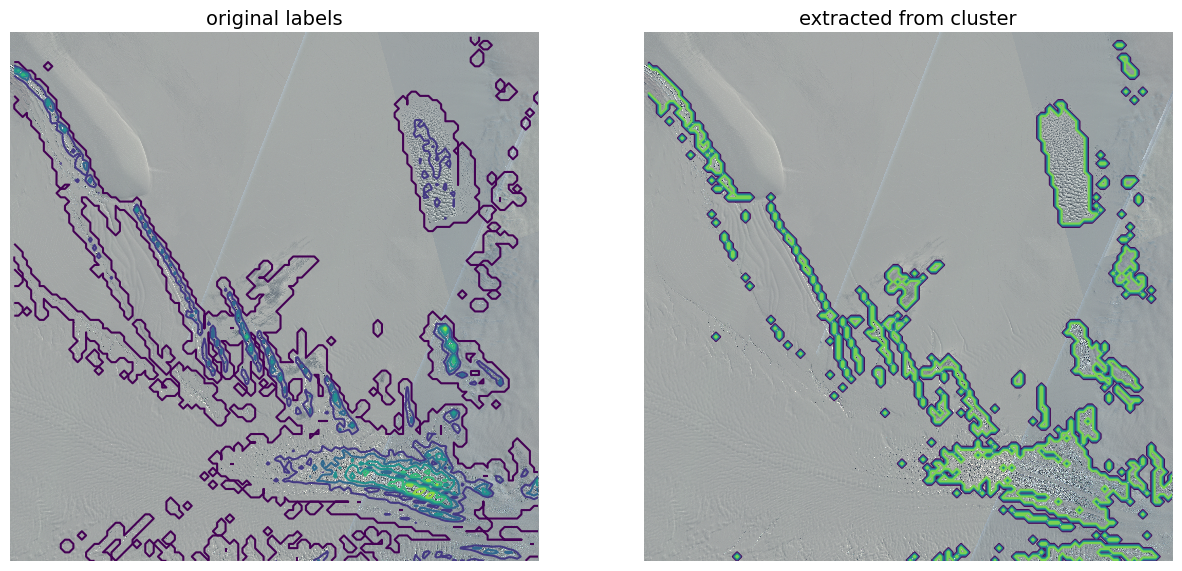

In [19]:
# overlap clusters with tile_da
da = tile_da.isel(band=[0,1,2])

# Plot tile

fig,axs= plt.subplots(1,2,figsize=(15,8))

# img
ax=axs[0]
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ax.set_aspect('equal')
ax.set_title('extracted from cluster')
# original labels
labels_da.transpose('band','y','x').isel(band=0).plot.contour(ax=ax)
ax.set_title('original labels',fontsize=14)
ax.set_axis_off()

# img
ax=axs[1]
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ax.set_aspect('equal')


# detected cluster
cluster_da.transpose('band','y','x').isel(band=0).plot.contour(ax=ax)
ax.set_title('extracted from cluster',fontsize=14)
ax.set_axis_off()

# fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_labels_vs_clusters2D.png'))


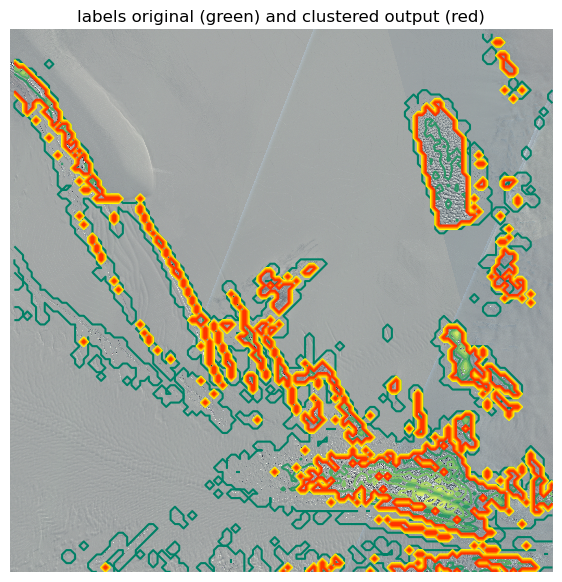

In [30]:
# overlap clusters with tile_da

# Plot tile

fig,axs= plt.subplots(1,figsize=(7,8))

# img
ax=axs
da.attrs['long_name']='imgbands';
da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1,cmap='gray',add_colorbar=True)
ax.set_aspect('equal')

# original labels
labels_da.transpose('band','y','x').isel(band=0).plot.contour(ax=ax,cmap='summer')

# detected cluster
cluster_da.transpose('band','y','x').isel(band=0).plot.contour(ax=ax,cmap='autumn_r')
ax.set_title('labels original (green) and clustered output (red)')
ax.set_axis_off()


# fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_labels_and_clusters2D.png'))

# DEV

In [21]:
# tile_cutouts_da.isel(band=[0],x_win=0,y_win=0
#                     )#.copy(deep=True, data=np.expand_dims(z0,axis=1) )  # copy array construct but replace data

# # Add detected cluster as new variable -- doesnt propagate when unstacking DA
# da_cluster = tile_cutouts_da.to_dataset(name='my_name').assign(d_detect=idx_cluster)
# da_cluster

# # Add detected cluster as extra band

# # idx_cluster to same shape as tile_da: repeat rows to fill windows
# idx_cluster_rep = np.tile( 
#                     np.expand_dims( 
#                         np.tile(np.expand_dims(idx_cluster,axis=1), cutout_size) ,axis=2) , 
#                     (1, 1, cutout_size) ) # ( Nsamples,xwin,ywin )
# idx_cluster_fill = np.expand_dims(idx_cluster_rep,axis=[3]) # (Nsamples,xwin,ywin,1)
# # # tile_da = (Nsamples, xwin, ywin, bands)
# # # add band (Nsamples,1) --> Nsamples, xwin, ywin, 1
# data_add_band = np.concatenate( [tile_cutouts_da.values, idx_cluster_fill ] , axis=3 ) # (Nsamples,xwin,ywin,band+1)

# # da_add_band = tile_cutouts_da.copy(deep=True, data= data_add_band )
# # da_add_band

# # construct new DA
# dmg_iceshelf = xr.DataArray( data = data_add_band,  # (Nsamples,xwin,ywin,band+1)
#                             coords={'y': (dmg_iceshelf["y"]),
#                                     'x': (dmg_iceshelf["x"]),
#                                     'time':([year])},
#                             name="dmg", 
#                             attrs=dmg_iceshelf.attrs, indexes=dmg_iceshelf.indexes)  # copy other properties

In [22]:

# # can I merge xwin and win, but then still unstack tile?
# tile_cutouts_aggr = tile_cutouts_da.mean('x_win').mean('y_win') # .unstack()
# tile_cutouts_aggr # (samples, bands)

# data_add_band = np.concatenate( [tile_cutouts_aggr.values, np.expand_dims(idx_cluster,axis=[1]) ] , axis=1 )
# data_add_band.shape

In [23]:
# idx_cluster.shape
# tile_cutouts_da

In [24]:
# data_fill = np.empty( tile_cutouts_da.isel(band=0).shape ) # Nsamples, xwin, ywin
# data_fill.shape
# data_fill[:,0,0] = idx_cluster
# data_fill.shape

# np.tile(np.expand_dims(idx_cluster,axis=1),(100,1,100)).shape
# idx_cluster_rep = np.tile( np.expand_dims( np.tile(np.expand_dims(idx_cluster,axis=1),cutout_size) ,axis=2) ,(1, 1, cutout_size) )
# idx_cluster_rep.shape



In [25]:
# # (idx_cluster*3)
# np.repeat( idx_cluster[:,np.newaxis] , 100, 1).shape

In [26]:
# idx_cluster_rep